### IMPORTING THE REQUIRED LIBRARIES AND SETTING UP PATH OF DIRECTORY ###

In [49]:

import os, shutil
import pathlib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  #info, warnings and error related to loaded libraries are not printed
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

import matplotlib.pyplot as plt
import numpy as np
from functools import partial


import tensorflow as tf
from tensorflow import keras


In [50]:
#check whether GPU is being used
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [51]:
# Directory containing train, test, validation images files in separate directories in the format to be loaded 

base_dir = '/home/kailash/VScode Python projects/tf/conv/small_dataset1/'

In [52]:
# Directories for train,valid,test images files

train_dir = os.path.join(base_dir,'train')

validation_dir = os.path.join(base_dir, 'validation')

test_dir = os.path.join(base_dir, 'test')

## Loading Dataset ##

In [53]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,batch_size=None)

Found 15000 files belonging to 2 classes.


In [54]:
class_names= train_ds.class_names
print(class_names)

['cats', 'dogs']


In [55]:
val_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,batch_size=None)

Found 5000 files belonging to 2 classes.


In [56]:
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,batch_size=24,image_size=(150,150),shuffle=False)

Found 5000 files belonging to 2 classes.


In [57]:
AUTOTUNE = tf.data.AUTOTUNE

In [58]:
train_ds

<ShuffleDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [59]:
val_ds

<ShuffleDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [60]:
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## AUGMENTATION AND OPTIMISATION ##

In [61]:
def normalize(image):
   '''returns the images that is scale to have mean=0 and variance = -1'''
   image =  tf.image.per_image_standardization(image)
   # img = image / tf.constant(256, dtype=tf.float32)
   # image = tf.image.resize_with_pad(image,150,150,method=tf.image.ResizeMethod.BILINEAR,antialias=True)
   image = tf.image.resize(image, [120, 120])
   return image



In [62]:
# layers for augmenting the images

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(40),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomTranslation(.2,.2),
  tf.keras.layers.RandomZoom(.2),
  tf.keras.layers.RandomHeight(.2),
  tf.keras.layers.RandomWidth(.2)])

In [63]:
def aug(image):
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=2)
    image = tf.image.random_contrast(image, 0.2, 0.5)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_saturation(image, 5, 10)
    return image

In [64]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(256, 256, 3)
()


In [65]:
AUTOTUNE = tf.data.AUTOTUNE

In [66]:
# def aug(ds,augment=False,shuffle = False):
#     '''returns dataset which is scaled and augmented such that process is optimised '''

#     ds = ds.map(lambda x, y: (normalize(x), y),num_parallel_calls=AUTOTUNE)

#     if shuffle:
#         ds = ds.shuffle(1000)

#     ds= ds.batch(40)

#     if augment:
#         ds = ds.map(lambda x,y : (tf.py_function(func=aug,inp=x,Tout=tf.float32),y),num_parallel_calls =AUTOTUNE)

    
#     return ds.prefetch(AUTOTUNE)

In [67]:
def aug(ds,augment=False,shuffle = False):
    '''returns dataset which is scaled and augmented such that process is optimised '''

    ds = ds.map(lambda x, y: (normalize(x), y),num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    ds= ds.batch(40)

    if augment:
        ds = ds.map(lambda x,y : (data_augmentation(x),y),num_parallel_calls =AUTOTUNE)

    
    return ds.prefetch(AUTOTUNE)

In [68]:
train_ds = aug(train_ds,augment=True,shuffle=True)
val_ds = aug(val_ds)



In [69]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [70]:
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

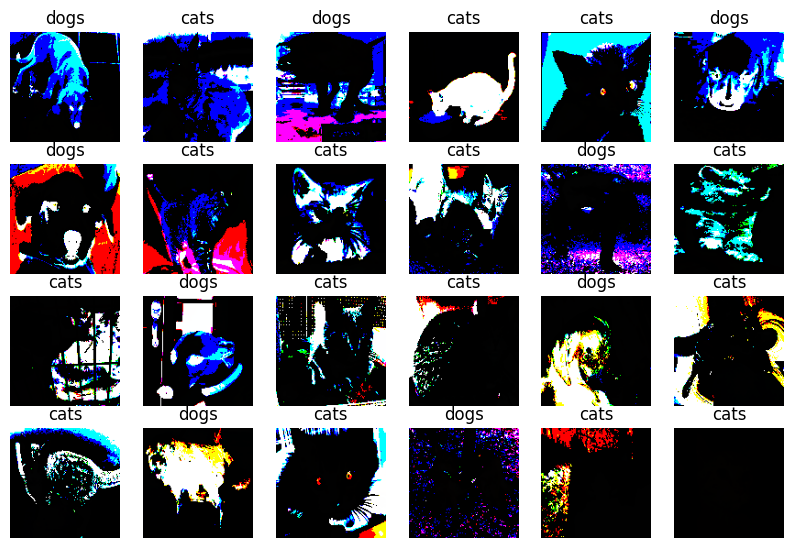

In [71]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(24):
        ax =plt.subplot(6,6,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [72]:
# image,label = next(iter(train_ds))

In [73]:
# image, label = next(iter(train_ds))


# _ = plt.imshow(np.array(image))

In [74]:
test_ds = test_ds.map(lambda x, y: (normalize(x), y))

In [75]:
test_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [76]:
# image, label = next(iter(test_ds))


# _ = plt.imshow(np.array(image))

## MODEL ARCHITECTURE ##

In [77]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(120,120,3))

In [78]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

In [79]:
Regularized_dense = partial(tf.keras.layers.Dense,
                             activation='selu',
                             kernel_regularizer = tf.keras.regularizers.l2(0.01))

In [80]:
Conv_2D = partial(tf.keras.layers.Conv2D,
                  kernel_size = 3,
                  strides =1,
                  padding = 'same',
                  activation = 'relu',
                  kernel_initializer = 'he_uniform')
                                       

In [81]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

## SEQUENTIAL API ##

In [82]:
# model = tf.keras.models.Sequential()

# model.add(conv_base)

# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(128, activation="relu",kernel_regularizer=keras.regularizers.l1_l2(0.01)))
# model.add(tf.keras.layers.BatchNormalization())

# model.add(tf.keras.layers.Dense(128,activation="relu",kernel_regularizer=keras.regularizers.l1_l2(0.01)))
# model.add(tf.keras.layers.BatchNormalization())

# model.add(tf.keras.layers.Dense(64,activation="relu",kernel_regularizer=keras.regularizers.l1_l2(0.01)))

# model.add(tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid))

## FUNCTIONAL API ##

In [83]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_global_policy(policy)

In [84]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [85]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [86]:
input = tf.keras.Input(shape = (120,120,3))

conv = conv_base(input)

flat = tf.keras.layers.Flatten()(conv)

drop1 = tf.keras.layers.Dropout(0.5)(flat)

dense2 = tf.keras.layers.Dense(516,activation='relu',kernel_regularizer=keras.regularizers.l1_l2(0.01))(drop1)

bn1 = tf.keras.layers.BatchNormalization()(dense2)

dense3 = tf.keras.layers.Dense(256,activation='relu',kernel_regularizer=keras.regularizers.l1_l2(0.01))(bn1)

bn2 = tf.keras.layers.BatchNormalization()(dense3)

drop2 = tf.keras.layers.Dropout(0.5)(bn2)

dense4 = tf.keras.layers.Dense(126,activation='relu',kernel_regularizer=keras.regularizers.l1_l2(0.01))(drop2)

dense5 = tf.keras.layers.Dense(1)(dense4)

output = tf.keras.layers.Activation('sigmoid',dtype='float32')(dense5)


model = tf.keras.Model(inputs = [input], outputs = [output], name = 'func_model' )


In [87]:
conv_base.trainable = True

In [88]:
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv' or 'block4_conv':
        set_trainable =  True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [89]:
# model = tf.keras.models.Sequential([

# tf.keras.layers.Conv2D(64,(5,5),strides=2,padding = "same",activation="relu",input_shape=(150,150,3)),
# tf.keras.layers.MaxPooling2D((2, 2)),

# Conv_2D(128),
# Conv_2D(128),
# tf.keras.layers.MaxPooling2D((2, 2)),


# Conv_2D(192),
# Conv_2D(192),
# tf.keras.layers.MaxPooling2D((2, 2)),

# Conv_2D(256),
# Conv_2D(256),
# tf.keras.layers.MaxPooling2D((2, 2)),

# tf.keras.layers.Flatten(),


# Regularized_dense(128),
# tf.keras.layers.Dropout(0.5),


# tf.keras.layers.BatchNormalization(),
# Regularized_dense(128),
# tf.keras.layers.Dropout(0.4),

# tf.keras.layers.BatchNormalization(),
# Regularized_dense(64),


# tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)

# ])

In [90]:
model.summary()

Model: "func_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dropout_2 (Dropout)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 516)               2378244   
                                                                 
 batch_normalization_2 (Batc  (None, 516)              2064      
 hNormalization)                                                 
                                                        

## COMPILING MODEL AND TRAINING THE MODEL

In [91]:

model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Nadam(learning_rate=.0001),metrics='acc')

In [92]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("cats_dog_classifier",save_best_only=True)

In [93]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [94]:
root_logdir = os.path.join(os.curdir, "Logs/tensorcore")
def get_run_logdir():
    import time
    run_id = "matplot"
    return os.path.join(root_logdir, run_id)


run_logdir = get_run_logdir()


In [95]:

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,profile_batch='20,30') 

In [96]:
history = model.fit(train_ds,epochs=1,validation_data=val_ds)

375/375 [==============================] - 86s 183ms/step - loss: 207.9367 - acc: 0.8109 - val_loss: 46.8092 - val_acc: 0.8734


## EVALUATION OF PERFORMANCE IN TENSORBOARD ##

In [97]:
test_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [98]:
test_labels = np.concatenate([y for x,y in test_ds])

In [99]:
test_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [100]:
model.evaluate(test_ds)

209/209 [==============================] - 6s 28ms/step - loss: 46.8287 - acc: 0.8636


[46.828651428222656, 0.8636000156402588]

In [101]:
pred_test = model.predict(test_ds)

209/209 [==============================] - 6s 26ms/step


In [102]:
pred_test

array([[0.13150747],
       [0.10894504],
       [0.10800066],
       ...,
       [0.79865825],
       [0.35588682],
       [0.8850366 ]], dtype=float32)

In [103]:
predictions = (model.predict(test_ds)>0.5).astype("int32")

209/209 [==============================] - 6s 26ms/step


In [104]:
# predictions

In [105]:
predictions = [p for pred in predictions for p in pred]

In [106]:
# predictions

In [107]:
incorrect = np.nonzero(predictions!=test_labels)

In [126]:
a = incorrect[0]

In [135]:
len(a)

682

In [125]:
test_plot = tf.keras.utils.image_dataset_from_directory(test_dir,batch_size=24,image_size=(120,120),shuffle=False)

Found 5000 files belonging to 2 classes.


In [127]:
test_images = np.concatenate([x for x,y in test_plot])

In [137]:
plt.figure(figsize=(100,100))

for i in range(len(a)):
    ax = plt.subplot(15,10,i)
    plt.imshow(test_images[a[i]].astype(np.uint8))
    plt.title(class_names[test_labels[i]])
    plt.axis("off")

ValueError: num must be 1 <= num <= 150, not 0

<Figure size 10000x10000 with 0 Axes>

: 

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 396 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

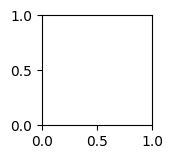

In [128]:
# plt.figure(figsize=(10,10))

# for images,labels in test_ds.take(1):
#     for i in range(len(a)):
#         ax =plt.subplot(6,6,i+1)
#         plt.imshow(images[a[i]].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")


In [113]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

In [114]:
cm = confusion_matrix(test_labels,predictions)
cm


array([[2493,    7],
       [ 675, 1825]])

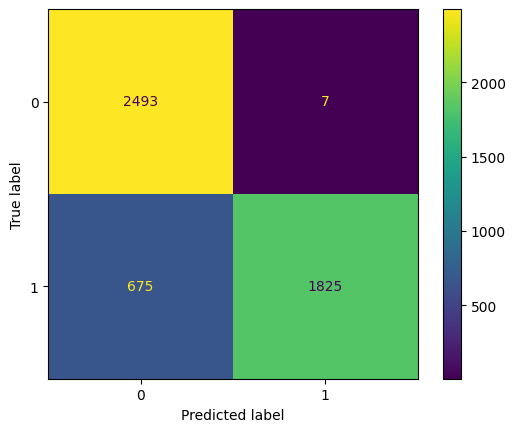

In [115]:
%matplotlib inline
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [116]:
print(classification_report(test_labels,predictions))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      2500
           1       1.00      0.73      0.84      2500

    accuracy                           0.86      5000
   macro avg       0.89      0.86      0.86      5000
weighted avg       0.89      0.86      0.86      5000



In [117]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [118]:
import pandas as pd

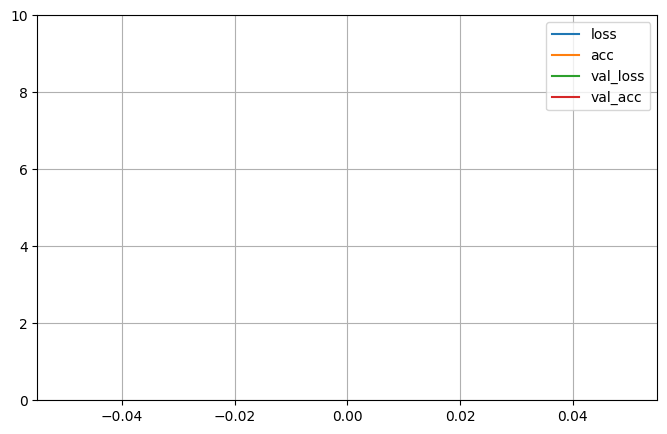

In [119]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 10) # set the vertical range to [0-1]
plt.show()

In [120]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard


In [121]:
%tensorboard  --logdir=./Logs/tensorcore

Reusing TensorBoard on port 6006 (pid 546089), started 0:43:21 ago. (Use '!kill 546089' to kill it.)

In [122]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances


Known TensorBoard instances:
  - port 6006: logdir ./Logs/cnn_layer_changes (started 2:07:26 ago; pid 414996)
  - port 6006: logdir ./Logs/tensorcore (started 0:43:21 ago; pid 546089)


In [123]:
notebook.display(port=6006, height=1000)


Selecting TensorBoard with logdir ./Logs/tensorcore (started 0:43:21 ago; port 6006, pid 546089).


In [124]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
